# 🔗 GitHub Repository and Full Tutorial

This notebook contains the runnable code for the tutorial: **"Understanding Convolution in CNNs: How Filters Learn Features."**

**GitHub Repository Link (Full Project, Report, and Code):**

https://github.com/AnuragNalla/Convolution_in_CNNs_Filter_Visualization?tab=readme-ov-file

---

--- Starting Model Training ---
Epoch [1/3], Loss: 0.1273
Epoch [2/3], Loss: 0.0146
Epoch [3/3], Loss: 0.0006

--- Generating Figure 1: Learned Filters ---


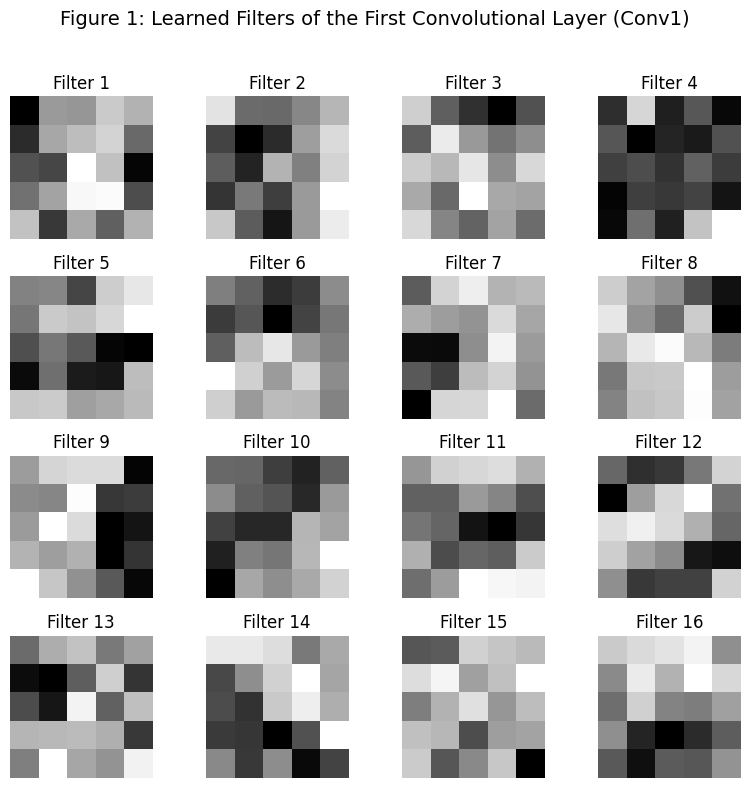


--- Generating Figure 2: Feature Maps ---


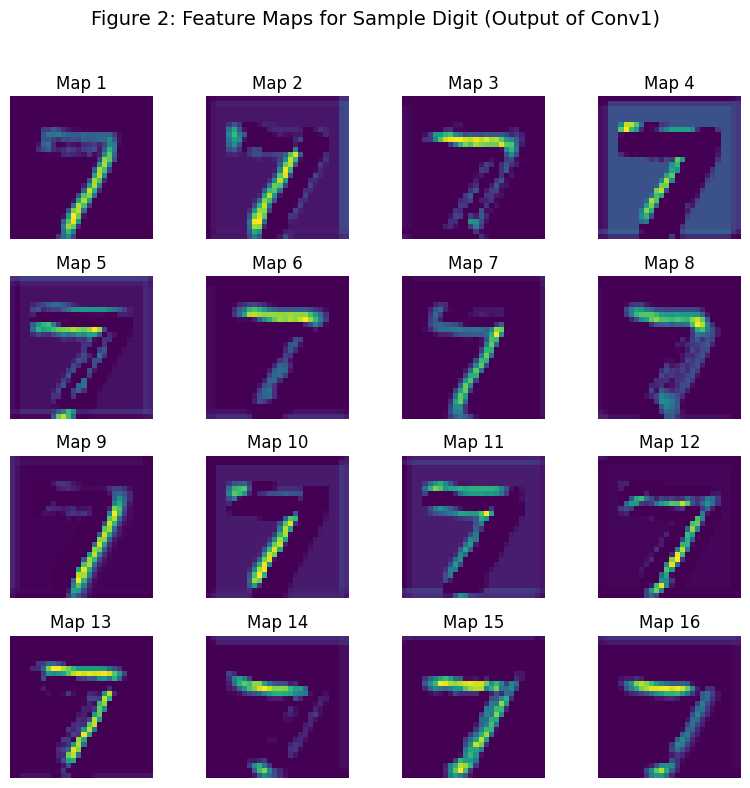


Final Model Test Accuracy: 98.92%


In [9]:
# ASSIGNMENT CODE: Understanding Convolution in CNNs: How Filters Learn Features
# Tutorial: Filter Visualization

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 3 # Keep low for quick demonstration
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# --- 2. DATA PREPARATION (MNIST) ---

# Standard normalization for grayscale images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. CNN MODEL DEFINITION ---

class SimpleCNN(nn.Module):
    """A small CNN for MNIST classification."""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Conv 1: The layer we will visualize
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 2: Deeper layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Final fully connected layer for classification
        self.fc = nn.Linear(7*7*32, 10) # Output size is 7x7 after 2 pooling layers

    def forward(self, x):
        # Feature Extraction
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))

        # Flatten for the classification layer
        out = out.reshape(out.size(0), -1)

        # Classification
        out = self.fc(out)
        return out

model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. TRAINING THE MODEL ---

print("--- Starting Model Training ---")
total_step = len(train_loader)
for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

# --- 5. VISUALIZATION 1: LEARNED FILTERS (Weights) ---
# This is the primary figure for the tutorial

def visualize_filters(model):
    # Extract weights from the first convolutional layer
    weights = model.conv1.weight.data.cpu().numpy()

    # Weights shape: (out_channels, in_channels, kernel_height, kernel_width)
    # For MNIST: (16, 1, 5, 5)

    num_filters = weights.shape[0]
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle('Figure 1: Learned Filters of the First Convolutional Layer (Conv1)', fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # Squeeze to remove the single channel dimension, normalize to 0-1 for plotting
            filter_img = weights[i, 0, :, :]

            # Use 'gray' colormap for clarity on grayscale features
            im = ax.imshow(filter_img, cmap='gray')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('Learned Filters of the First Convolutional Layer (Conv1).png')
    plt.show()

print("\n--- Generating Figure 1: Learned Filters ---")
visualize_filters(model)


# --- 6. VISUALIZATION 2: FEATURE MAPS (Activations) ---
# Shows the output of the first layer for a specific input

def visualize_feature_maps(model, sample_image):
    model.eval()

    # Pass the image through the first Conv layer
    with torch.no_grad():
        # Get output from the ReLU after Conv1 and Pooling
        activation = model.relu1(model.conv1(sample_image.to(DEVICE).unsqueeze(0)))

    activation = activation.squeeze(0).cpu().numpy()

    # Activation shape: (out_channels, height, width) -> (16, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f'Figure 2: Feature Maps for Sample Digit (Output of Conv1)', fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < activation.shape[0]:
            # Plot the activation map (output of one filter)
            ax.imshow(activation[i, :, :], cmap='viridis') # Use 'viridis' for activation visualization
            ax.set_title(f'Map {i+1}')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('Feature Maps for Sample Digit (Output of Conv1).png')
    plt.show()

# Get a sample image from the test set (e.g., the first one)
sample_image, _ = test_dataset[0]
print("\n--- Generating Figure 2: Feature Maps ---")
visualize_feature_maps(model, sample_image)

# --- 7. Final Test Accuracy (Optional but Recommended) ---
# Used to show the model actually learned something useful

def calculate_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

test_accuracy = calculate_test_accuracy(model, test_loader)
print(f'\nFinal Model Test Accuracy: {test_accuracy:.2f}%')